In [1]:
import os
import matplotlib.pyplot as plt
import sys
import pickle as pkl
from argparse import ArgumentParser
from copy import deepcopy
from os.path import join as oj
import numpy as np
import pickle
import random
import configparser
import torch
from torch import nn
import torch.utils.data
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import csv
import optuna

sys.path.insert(0, "../1D CNN")
import utils
import models
import data_fns
import my_eval


random.seed(0)
np.random.seed()

config = configparser.ConfigParser()
config.read("../config.ini")
torch.backends.cudnn.deterministic = True

def get_args():
    parser = ArgumentParser(description="Functional group analysis")

    parser.add_argument("--exp_name", type=str, default="")
    parser.add_argument("--batch_size", type=int, default=128)
    parser.add_argument("--num_epochs", type=int, default=1000)
    parser.add_argument("--seed", type=int, default=0)

    parser.add_argument("--num_conv", type=int, default=16)
    parser.add_argument("--patience", type=int, default=10)
    ret_args, unknown = parser.parse_known_args()
    return ret_args


args = get_args()


# data = np.load("data.npy")
# labels = np.load('labels.npy')

# filters = (("state", "gas"), ("yunits", "ABSORBANCE"), ("xunits", "1/CM"))
# data, labels = utils.fixed_domain_filter(
#     irdata, irindex, filters
# )  # Filter points from the dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()


file_path = "TS_freq_array_0208_new.csv"
save_path = "C:\\Users\\aethe\\1D CNN"
# Initialize arrays
y_labels = []
x_TS = []
fish_num = []
final_labels = []

# Read the CSV file line by line
with open(file_path, 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    
    next(csv_reader)
    
    # Extract the first column and construct rows as arrays
    for row in csv_reader:
        fish_num.append(row[0])
        y_labels.append(row[-2])
        final_labels.append([row[-2],row[-1]])
        x_TS.append(row[2:-2])


x_TS = np.array(x_TS, dtype = float)

print(x_TS.shape) # (32954, 249)

means = np.mean(x_TS, axis=0)
std_devs = np.std(x_TS, axis=0)
x_TS = (x_TS - means) / std_devs  # Standardizing data


# Contruct data and labels
data = x_TS[:, None]
labels = np.array(y_labels, dtype=int)
final_labels = np.array(final_labels, dtype=int)

# When spliting the dataset, we first split based on each fish to aviod data leakage
# Create a mapping dictionary from fish_num to indices

fish_num_to_index = {fish_num: index for index, fish_num in enumerate(np.unique(np.array(fish_num)))}

# Use the mapping to convert the fish_num to indices
fish_ind = np.array([fish_num_to_index[num] for num in fish_num])


train_idxs_by_fish, val_idxs_by_fish, test_idxs_by_fish = data_fns.get_split(len(np.unique(fish_ind)), seed=23)

# Checn index split by fish
print(train_idxs_by_fish)
print(val_idxs_by_fish)
print(test_idxs_by_fish)


# This function takes in the indices that split by individual fish
# It then returns the indices split by each time ping correspond to the individual fish
def construct_data_index_by_fish_idxs(idxs_split_by_fish, fish_ind):
    indx = np.array([], dtype=int)  # Ensure the array is of integer type
    for split_fish_ind in idxs_split_by_fish:
        # Ensure split_fish_ind is an integer before using it as an index
        split_fish_ind = int(split_fish_ind)
        indx_current_fish = np.where(fish_ind == split_fish_ind)[0]
        indx = np.append(indx, indx_current_fish)

    return indx



# Indices that we use in the model
train_idxs = construct_data_index_by_fish_idxs(train_idxs_by_fish, fish_ind)
val_idxs = construct_data_index_by_fish_idxs(val_idxs_by_fish, fish_ind)
test_idxs = construct_data_index_by_fish_idxs(test_idxs_by_fish, fish_ind)


print(train_idxs.shape) # (23208,)
print(val_idxs.shape) # (5182,)
print(test_idxs.shape) # (4564,)


num_classes = 2

#%%
# create datasets in torch
torch.manual_seed(args.seed)
train_dataset = TensorDataset(
    *[torch.Tensor(input) for input in [data[train_idxs], final_labels[train_idxs]]],
)
val_dataset = TensorDataset(
    *[torch.Tensor(input) for input in [data[val_idxs], final_labels[val_idxs]]],
)

test_dataset = TensorDataset(
    *[torch.Tensor(input) for input in [data[test_idxs], final_labels[test_idxs]]],
)




train_loader = DataLoader(
    train_dataset,
    batch_size=args.batch_size,
    shuffle=True,
)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=True)
print(num_classes)



model = models.FGANet(
    num_input=data.shape[2],
    num_output=2,
    conv_channels=args.num_conv,
    num_in_channels=data.shape[1],
    stride=1,
).to(device)






Using device: cpu

(32954, 249)
[14 18 17 32 13 33 20  8 36 28 29 10 44  3 22 48 30 35 24 23  4 42  7  1
 49 41 45 15 46 16 34 37  0  5 21]
[11  2 43  6 25 26 39]
[27 12 31 47  9 40 38 19]
(23208,)
(5182,)
(4564,)
2


In [2]:
fish_num_to_index

{'LT009': 0,
 'LT010': 1,
 'LT011': 2,
 'LT012': 3,
 'LT014': 4,
 'LT015': 5,
 'LT016': 6,
 'LT017': 7,
 'LT018': 8,
 'LT021': 9,
 'LT23002': 10,
 'LT23003': 11,
 'LT23004': 12,
 'LT23005': 13,
 'LT23007': 14,
 'LT23009': 15,
 'LT23010': 16,
 'LT23011': 17,
 'LT23012': 18,
 'LT23013': 19,
 'SMB001': 20,
 'SMB002': 21,
 'SMB005': 22,
 'SMB006': 23,
 'SMB007': 24,
 'SMB010': 25,
 'SMB011': 26,
 'SMB012': 27,
 'SMB23001': 28,
 'SMB23002': 29,
 'SMB23003': 30,
 'SMB23004': 31,
 'SMB23005': 32,
 'SMB23006': 33,
 'SMB23007': 34,
 'SMB23008': 35,
 'SMB23009': 36,
 'SMB23010': 37,
 'SMB23011': 38,
 'SMB23012': 39,
 'SMB23013': 40,
 'SMB23014': 41,
 'SMB23015': 42,
 'SMB23016': 43,
 'SMB23017': 44,
 'SMB23018': 45,
 'SMB23019': 46,
 'SMB23020': 47,
 'SMB23021': 48,
 'SMB23022': 49}

In [2]:
count_0s = np.sum(labels == 0)
count_1s = np.sum(labels == 1)

# Calculate the total number of items for calculating proportions
total_count = labels.size

# Calculate the proportion of 0s and 1s
proportion_of_0s = count_0s / total_count
proportion_of_1s = count_1s / total_count

print(f"Proportion of 0s: {proportion_of_0s}")
print(f"Proportion of 1s: {proportion_of_1s}")
print(total_count)

Proportion of 0s: 0.3587424895308612
Proportion of 1s: 0.6412575104691388
32954


In [3]:
filtered_data = labels[train_idxs]

# Count the number of 0s and 1s
count_0s = np.sum(filtered_data == 0)
count_1s = np.sum(filtered_data == 1)

# Calculate the total number of items for calculating proportions
total_count = filtered_data.size

# Calculate the proportion of 0s and 1s
train_proportion_of_0s = count_0s / total_count
train_proportion_of_1s = count_1s / total_count

print(f"Proportion of 0s: {train_proportion_of_0s}")
print(f"Proportion of 1s: {train_proportion_of_1s}")
print(total_count)

Proportion of 0s: 0.39887107893829715
Proportion of 1s: 0.6011289210617029
23208


In [4]:
filtered_data = labels[val_idxs]

# Count the number of 0s and 1s
count_0s = np.sum(filtered_data == 0)
count_1s = np.sum(filtered_data == 1)

# Calculate the total number of items for calculating proportions
total_count = filtered_data.size

# Calculate the proportion of 0s and 1s
val_proportion_of_0s = count_0s / total_count
val_proportion_of_1s = count_1s / total_count

print(f"Proportion of 0s: {val_proportion_of_0s}")
print(f"Proportion of 1s: {val_proportion_of_1s}")
print(total_count)

Proportion of 0s: 0.1669239675800849
Proportion of 1s: 0.8330760324199151
5182


In [5]:
filtered_data = labels[test_idxs]

# Count the number of 0s and 1s
count_0s = np.sum(filtered_data == 0)
count_1s = np.sum(filtered_data == 1)

# Calculate the total number of items for calculating proportions
total_count = filtered_data.size

# Calculate the proportion of 0s and 1s
test_proportion_of_0s = count_0s / total_count
test_proportion_of_1s = count_1s / total_count

print(f"Proportion of 0s: {test_proportion_of_0s}")
print(f"Proportion of 1s: {test_proportion_of_1s}")
print(total_count)

Proportion of 0s: 0.37248028045574055
Proportion of 1s: 0.6275197195442594
4564


In [6]:
from sklearn.metrics import roc_auc_score

Epoch: 1, TrLoss: 0.27842, ValLoss: 0.34528, ValAcc: 0.73, ValSen:0.95, ValSpe:0.52
Epoch: 2, TrLoss: 0.23628, ValLoss: 0.28894, ValAcc: 0.79, ValSen:0.94, ValSpe:0.63
Epoch: 3, TrLoss: 0.21391, ValLoss: 0.30668, ValAcc: 0.78, ValSen:0.93, ValSpe:0.64
Epoch: 4, TrLoss: 0.20013, ValLoss: 0.25547, ValAcc: 0.82, ValSen:0.94, ValSpe:0.70
Epoch: 5, TrLoss: 0.18841, ValLoss: 0.27378, ValAcc: 0.82, ValSen:0.96, ValSpe:0.67
Epoch: 6, TrLoss: 0.18377, ValLoss: 0.28205, ValAcc: 0.80, ValSen:0.95, ValSpe:0.66
Epoch: 7, TrLoss: 0.17349, ValLoss: 0.27287, ValAcc: 0.82, ValSen:0.96, ValSpe:0.68
Epoch: 8, TrLoss: 0.17037, ValLoss: 0.26204, ValAcc: 0.82, ValSen:0.95, ValSpe:0.69
Epoch: 9, TrLoss: 0.16412, ValLoss: 0.22735, ValAcc: 0.84, ValSen:0.93, ValSpe:0.75
Epoch: 10, TrLoss: 0.16033, ValLoss: 0.23503, ValAcc: 0.84, ValSen:0.94, ValSpe:0.73
Epoch: 11, TrLoss: 0.15555, ValLoss: 0.26733, ValAcc: 0.83, ValSen:0.96, ValSpe:0.69
Epoch: 12, TrLoss: 0.15416, ValLoss: 0.28193, ValAcc: 0.81, ValSen:0.95, V

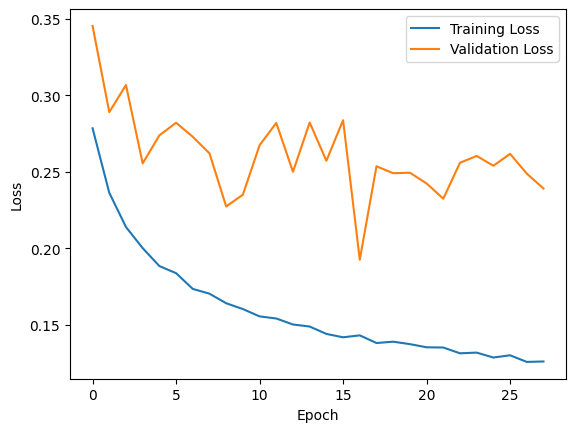

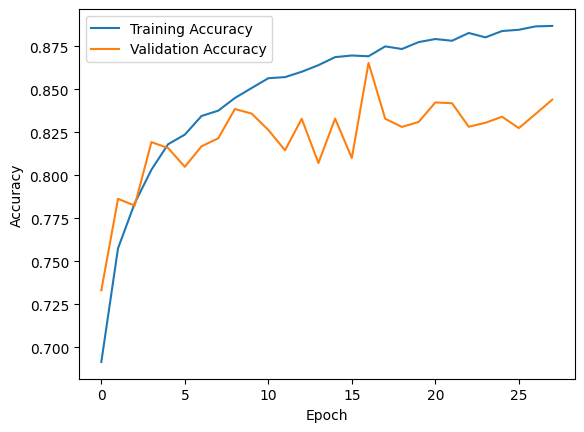

Training finished
0.8285117482747288
0.8494117647058823
0.8076117318435754
0.24099952893124688
Test AUC:  0.8842490962865595


In [7]:
import torch
import torch.nn as nn
from torch.optim import Adam
from copy import deepcopy

def train(model, train_loader, val_loader, device, num_epochs=1000, batch_size=128,max_patience=20):
    optimizer = optim.Adam(model.parameters(),weight_decay=0.001)
    # optimizer = optim.Adam(model.parameters(),)
    # lambda2 = lambda epoch: 0.8 ** epoch
    # scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=0.001, last_epoch=-1)

    training_loss = []
    train_accs = []
    val_losses = []
    val_accs = []

    
    best_val_loss = 500000
    best_weights = None
    cur_patience = 0
    train_class_weights = torch.tensor([train_proportion_of_0s, train_proportion_of_1s], dtype=torch.float).to(device)
    for epoch in range(num_epochs):
        model.train()
        tr_loss = 0
        train_true_positives = 0
        train_true_negatives = 0
        train_false_positives = 0
        train_false_negatives = 0
        for _, (data_cur, labels_cur) in enumerate(train_loader):
            data_cur, labels_cur = data_cur.to(device), labels_cur.to(device)
            optimizer.zero_grad()

            y_pred = model(data_cur).squeeze()  # Ensure y_pred is of the right shape
            cur_loss = nn.functional.binary_cross_entropy(
                    y_pred, labels_cur, reduction="mean", weight = train_class_weights
                )  # Ensure labels_cur is float
            # l2_lambda = 0.001
            # l2_norm = sum(p.pow(2.0).sum() for p in model.features[-5].parameters())
            # (cur_loss+l2_lambda*l2_norm).backward()
            cur_loss.backward()
            tr_loss += cur_loss.item() 
            optimizer.step()
            # scheduler.step()
            y_pred_classes = y_pred.argmax(dim=1)  # Convert probabilities to class indices [0 or 1]
            labels_classes = labels_cur.argmax(dim=1)  # Convert one-hot labels to class indices [0 or 1]
            # train_corr = (y_pred_classes == labels_classes).sum().item()
            # train_acc += train_corr
            train_true_positives += ((y_pred_classes == 1) & (labels_classes == 1)).sum().item()
            train_true_negatives += ((y_pred_classes == 0) & (labels_classes == 0)).sum().item()
            train_false_positives += ((y_pred_classes == 1) & (labels_classes == 0)).sum().item()
            train_false_negatives += ((y_pred_classes == 0) & (labels_classes == 1)).sum().item()
            
            

        # train_acc /= len(train_loader.dataset)
        train_sensitivity = train_true_positives / (train_true_positives + train_false_negatives) 
        train_specificity = train_true_negatives / (train_true_negatives + train_false_positives) 
        train_balanced_accuracy = (train_sensitivity + train_specificity) / 2
        tr_loss /= len(train_loader)
        training_loss.append(tr_loss)
        train_accs.append(train_balanced_accuracy)
        # Validation loop
        model.eval()
        val_loss = 0
        val_true_positives = 0
        val_true_negatives = 0
        val_false_positives = 0
        val_false_negatives = 0
        val_class_weights = torch.tensor([val_proportion_of_0s, val_proportion_of_1s], dtype=torch.float).to(device)
        with torch.no_grad():
            for _, (data_cur, labels_cur) in enumerate(val_loader):
                data_cur, labels_cur = data_cur.to(device), labels_cur.to(device)
                y_pred = model(data_cur).squeeze()  # Ensure y_pred is of the right shape

                cur_loss =nn.functional.binary_cross_entropy(y_pred, labels_cur , reduction="mean", weight = val_class_weights)  # Ensure labels_cur is float
                val_loss += cur_loss.item()

                # Use the highest probability
                y_pred_classes = y_pred.argmax(dim=1)  # Convert probabilities to class indices [0 or 1]
                labels_classes = labels_cur.argmax(dim=1)  # Convert one-hot labels to class indices [0 or 1]
                # val_corr = (y_pred_classes == labels_classes).sum().item()
                # val_acc += val_corr
                val_true_positives += ((y_pred_classes == 1) & (labels_classes == 1)).sum().item()
                val_true_negatives += ((y_pred_classes == 0) & (labels_classes == 0)).sum().item()
                val_false_positives += ((y_pred_classes == 1) & (labels_classes == 0)).sum().item()
                val_false_negatives += ((y_pred_classes == 0) & (labels_classes == 1)).sum().item()

        # val_acc /= len(val_loader.dataset)
        val_sensitivity = val_true_positives / (val_true_positives + val_false_negatives) 
        val_specificity = val_true_negatives / (val_true_negatives + val_false_positives) 
        val_balanced_accuracy = (val_sensitivity + val_specificity) / 2
        val_loss /= len(val_loader)

        val_losses.append(val_loss)
        val_accs.append(val_balanced_accuracy)

        print(f"Epoch: {epoch+1}, TrLoss: {tr_loss:.5f}, ValLoss: {val_loss:.5f}, ValAcc: {val_balanced_accuracy:.2f}, ValSen:{val_sensitivity:.2f}, ValSpe:{val_specificity:.2f}")

        # Early stopping condition
        if val_loss < best_val_loss:
            best_weights = deepcopy(model.state_dict())
            cur_patience = 0
            best_val_loss = val_loss
        # if val_acc > best_val_acc:
        #     best_weights = deepcopy(model.state_dict())
        #     cur_patience = 0
        #     best_val_acc = val_acc
            
        else:
            cur_patience += 1

        if cur_patience > max_patience:
            print("Early stopping due to no improvement in validation accuracy")
            break
    plt.plot(training_loss, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss_plot.png')  
    plt.show()
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('accuracy_plot.png')
    plt.show()
    print("Training finished")
    
    model.load_state_dict(best_weights)
    model.eval()
    test_loss = 0
    test_true_positives = 0
    test_true_negatives = 0
    test_false_positives = 0
    test_false_negatives = 0
    test_class_weights = torch.tensor([test_proportion_of_0s, test_proportion_of_1s], dtype=torch.float).to(device)
    predictions = []
    true_labels = []

    with torch.no_grad():
        for _, (data_cur, labels_cur) in enumerate(test_loader):
            data_cur, labels_cur = data_cur.to(device), labels_cur.to(device)
            y_pred = model(data_cur).squeeze()  # Ensure y_pred is of the right shape

            cur_loss =nn.functional.binary_cross_entropy(y_pred, labels_cur , reduction="mean", weight = test_class_weights)  # Ensure labels_cur is float
            test_loss += cur_loss.item()
            
                # Use the highest probability
            y_pred_classes = y_pred.argmax(dim=1)  # Convert probabilities to class indices [0 LT or 1 BASS]
            labels_classes = labels_cur.argmax(dim=1)  # Convert one-hot labels to class indices [0 or 1]
            test_true_positives += ((y_pred_classes == 1) & (labels_classes == 1)).sum().item()
            test_true_negatives += ((y_pred_classes == 0) & (labels_classes == 0)).sum().item()
            test_false_positives += ((y_pred_classes == 1) & (labels_classes == 0)).sum().item()
            test_false_negatives += ((y_pred_classes == 0) & (labels_classes == 1)).sum().item()

    # test_acc /= len(test_loader.dataset)
    test_sensitivity = test_true_positives / (test_true_positives + test_false_negatives) #bass
    test_specificity = test_true_negatives / (test_true_negatives + test_false_positives) 
    test_balanced_accuracy = (test_sensitivity + test_specificity) / 2
    test_loss /= len(test_loader)
    print(test_balanced_accuracy)
    print(test_sensitivity)
    print(test_specificity)
    print(test_loss)
    np.random.seed()

    file_name = "".join([str(np.random.choice(10)) for x in range(10)])

    results = {}
    results["filename"] = file_name
    for arg in vars(args):
        if arg != "save_path":
            results[str(arg)] = getattr(args, arg)
    results["train_losses"] = training_loss
    results["val_losses"] = val_losses
    results["val_acc"] = val_accs
    results["best_val_loss"] = best_val_loss
    results["test_loss"] = test_loss
    results["test_acc"] = test_balanced_accuracy
    results["test_auc"] = my_eval.calculate_roc_auc_score(
        model, device, data[test_idxs], final_labels[test_idxs], batch_size
    )
    print("Test AUC: ", results["test_auc"])

    # pkl.dump(results, open(os.path.join(save_path, file_name + ".pkl"), "wb"))
    # torch.save(model.state_dict(), oj(save_path, file_name + ".pt"))
    # print("Saved model and results")

    return results



if __name__ == "__main__":
    train(model, train_loader, val_loader, device,
        num_epochs=args.num_epochs,
        max_patience=args.patience,
        batch_size=args.batch_size,
    )

In [3]:
model = models.FGANet(
    num_input=data.shape[2],
    num_output=2,
    conv_channels=args.num_conv,
    num_in_channels=data.shape[1],
    stride=1,)
model.eval()
dummy_input = torch.randn(1, data.shape[1], 249)
with torch.no_grad():
    x = dummy_input
    for layer in model.features:
        x = layer(x)
        print(layer.__class__.__name__, "output shape:", x.shape)

Conv1d output shape: torch.Size([1, 16, 247])
ReLU output shape: torch.Size([1, 16, 247])
Dropout output shape: torch.Size([1, 16, 247])
BatchNorm1d output shape: torch.Size([1, 16, 247])
Conv1d output shape: torch.Size([1, 16, 245])
ReLU output shape: torch.Size([1, 16, 245])
Dropout output shape: torch.Size([1, 16, 245])
BatchNorm1d output shape: torch.Size([1, 16, 245])
MaxPool1d output shape: torch.Size([1, 16, 122])
Conv1d output shape: torch.Size([1, 32, 120])
ReLU output shape: torch.Size([1, 32, 120])
Dropout output shape: torch.Size([1, 32, 120])
BatchNorm1d output shape: torch.Size([1, 32, 120])
Conv1d output shape: torch.Size([1, 32, 118])
ReLU output shape: torch.Size([1, 32, 118])
Dropout output shape: torch.Size([1, 32, 118])
MaxPool1d output shape: torch.Size([1, 32, 59])
BatchNorm1d output shape: torch.Size([1, 32, 59])
Conv1d output shape: torch.Size([1, 64, 57])
ReLU output shape: torch.Size([1, 64, 57])
Dropout output shape: torch.Size([1, 64, 57])
BatchNorm1d output

model.features

In [14]:
model.features

Sequential(
  (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,))
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Conv1d(16, 16, kernel_size=(3,), stride=(1,))
  (5): ReLU()
  (6): Dropout(p=0.3, inplace=False)
  (7): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv1d(16, 32, kernel_size=(3,), stride=(1,))
  (10): ReLU()
  (11): Dropout(p=0.3, inplace=False)
  (12): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (14): ReLU()
  (15): Dropout(p=0.4, inplace=False)
  (16): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (18): Conv1d(32, 32, kernel_size=(3,), stride=(1,))